# Predict Future Sales

## 预处理

### 训练集&测试

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
train = pd.read_csv('dataset/sales_train.csv.zip')
test= pd.read_csv('dataset/test.csv.zip')
print(train.head())
print(test.head())
print('训练集的商店数量： %d ，商品数量： %d；\n' % (train['shop_id'].unique().size, 
                                     train['item_id'].unique().size), 
      '测试的商店数量： %d，商品数量： %d。' % (test['shop_id'].unique().size, 
                                 test['item_id'].unique().size))

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
训练集的商店数量： 60 ，商品数量： 21807；
 测试的商店数量： 42，商品数量： 5100。


### 商店数据集

In [5]:
shops = pd.read_csv('dataset/shops.csv')
print(shops.head())

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4


经过谷歌翻译和百度翻译得知这个是俄罗斯的语言。其中有几个相同商店名称但是不同ID的店铺
- 39号： РостовНаДону ТРК "Мегацентр Горизонт"
- 40号： РостовНаДону ТРК "Мегацентр Горизонт" Островной
上面这两个商店名，差别在最后一个单词，翻译是“岛”，但是在谷歌地图中查找俄罗斯包含“Мегацентр Горизонт”这个名字的购物中心只有РостовНаДону ТРК这个地方上有且只有一个。推测这两个是同一个商店不同叫法。

- 10号： Жуковский ул. Чкалова 39м?
- 11号： Жуковский ул. Чкалова 39м2
这两个推测是书写不一致导致的。

- 0号： !Якутск Орджоникидзе, 56 фран
- 57号： !Якутск Орджоникидзе, 56
这两个也是书写的不一致的问题，类似某某街道56，和某某街道56号的区别。

- 58号：Якутск ТЦ "Центральный"
- 1号： !Якутск ТЦ "Центральный" фран
同上。

- 12 和 56 是线上商店 

In [6]:
# 查看测试集是否包含了这几个商店
test[test['shop_id'].isin([39, 40, 10, 11, 0, 57, 58, 1, 12 ,56])]['shop_id'].unique()

array([10, 12, 57, 58, 56, 39])

In [7]:
# 测试集中没有包含同一商店的不同ID， 需要对训练集重复商店的不同ID进行修改，修改的ID则以测试集为准。
shop_id_map = {11: 10, 0: 57, 1: 58, 40: 39}
train.loc[train['shop_id'].isin(shop_id_map), 'shop_id'] = train.loc[train['shop_id'].isin(shop_id_map), 'shop_id'].map(shop_id_map)
train.loc[train['shop_id'].isin(shop_id_map), 'shop_id']

Series([], Name: shop_id, dtype: int64)

In [8]:
train.loc[train['shop_id'].isin([39, 40, 10, 11, 0, 57, 58, 1]), 'shop_id'].unique()

array([57, 58, 10, 39])

对商店名称进行简单分析后，发现商店名称有一个命名规律，大部分商店的名称：
- 开头是一个地区的名称；
- 中间是商店的规模（比如购物中心：ТЦ、大型购物娱乐中心：ТРЦ等）；
- 尾部带引号的是商店的名称，比如‘xxx’购物中心，大部分可以在谷歌地图上搜索到。

In [9]:
shops['shop_city'] = shops['shop_name'].map(lambda x:x.split(' ')[0].strip('!'))
shop_types = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК', 'МТРЦ']
shops['shop_type'] = shops['shop_name'].map(lambda x:x.split(' ')[1] if x.split(' ')[1] in shop_types else 'Others')
shops.loc[shops['shop_id'].isin([12, 56]), ['shop_city', 'shop_type']] = 'Online'  # 12和56号是网上商店
shops.head(13)

,shop_name,shop_id,shop_city,shop_type
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,Others
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,ТРЦ
6,"Воронеж (Плехановская, 13)",6,Воронеж,Others
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,ТРЦ
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,ТРЦ
9,Выездная Торговля,9,Выездная,Others


In [10]:
# 对商店信息进行编码，降低模型训练的内存消耗
shop_city_map = dict([(v,k) for k, v in enumerate(shops['shop_city'].unique())])
shop_type_map = dict([(v,k) for k, v in enumerate(shops['shop_type'].unique())])
shops['shop_city_code'] = shops['shop_city'].map(shop_city_map)
shops['shop_type_code'] = shops['shop_type'].map(shop_type_map)
shops.head(7)

,shop_name,shop_id,shop_city,shop_type,shop_city_code,shop_type_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,Others,0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ,0,1
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ,1,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК,2,2
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ,3,1
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,ТРЦ,4,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,Others,5,0


### 商品数据集

In [13]:
items = pd.read_csv('dataset/items.csv.zip')
items.head(7)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40


In [14]:
# 数据集比较大，只分析有没有重复名称不同ID的商品
items['item_name'] = items['item_name'].map(lambda x: ''.join(x.split(' ')))  # 删除空格
duplicated_item_name = items[items['item_name'].duplicated()]
duplicated_item_name

,item_name,item_id,item_category_id
2558,DEEPPURPLEComeHellOrHighWaterDVD,2558,59
2970,"Divinity:DragonCommander[PC,Цифроваяверсия]",2970,31
5063,NIRVANAUnpluggedInNewYorkLP,5063,58
14539,МЕНЯЮЩИЕРЕАЛЬНОСТЬ(регион),14539,40
19475,СтругацкиеА.иБ.Улитканасклоне(mp3-CD)(Jewel),19475,43
19581,ТАРЗАН(BD),19581,37


In [15]:
duplicated_item_name_rec = items[items['item_name'].isin(duplicated_item_name['item_name'])]  # 6个商品相同名字不同id的记录
duplicated_item_name_rec

,item_name,item_id,item_category_id
2514,DEEPPURPLEComeHellOrHighWaterDVD,2514,59
2558,DEEPPURPLEComeHellOrHighWaterDVD,2558,59
2968,"Divinity:DragonCommander[PC,Цифроваяверсия]",2968,31
2970,"Divinity:DragonCommander[PC,Цифроваяверсия]",2970,31
5061,NIRVANAUnpluggedInNewYorkLP,5061,58
5063,NIRVANAUnpluggedInNewYorkLP,5063,58
14537,МЕНЯЮЩИЕРЕАЛЬНОСТЬ(регион),14537,40
14539,МЕНЯЮЩИЕРЕАЛЬНОСТЬ(регион),14539,40
19465,СтругацкиеА.иБ.Улитканасклоне(mp3-CD)(Jewel),19465,43
19475,СтругацкиеА.иБ.Улитканасклоне(mp3-CD)(Jewel),19475,43


In [16]:
# 依旧是查看测试里面包含了哪一些重复项】
test[test['item_id'].isin(duplicated_item_name_rec['item_id'])]['item_id'].unique()

array([19581,  5063])

In [17]:
# 测试集包含了2个同名不同id的商品。且都是较大的ID值。需要把训练集里小的ID值都映射为对应较大的ID值
old_id = duplicated_item_name_rec['item_id'].values[::2]
new_id = duplicated_item_name_rec['item_id'].values[1::2]
old_new_map = dict(zip(old_id, new_id))
old_new_map

{2514: 2558, 2968: 2970, 5061: 5063, 14537: 14539, 19465: 19475, 19579: 19581}

In [18]:
train.loc[train['item_id'].isin(old_id), 'item_id'] = train.loc[train['item_id'].isin(old_id), 'item_id'].map(old_new_map)
train[train['item_id'].isin(old_id)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [19]:
train[train['item_id'].isin(duplicated_item_name_rec['item_id'].values)]['item_id'].unique()  # 旧id成功替换成新id

array([ 2558, 14539, 19475, 19581,  5063,  2970])

### 商品类目数据集

In [20]:
items.groupby('item_id').size()[items.groupby('item_id').size() > 1]  # 检查同一个商品是否分了不同类目

Series([], dtype: int64)

In [22]:
cat = pd.read_csv('dataset/item_categories.csv')
cat.head(7)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6


In [23]:
cat[cat['item_category_name'].duplicated()]

,item_category_name,item_category_id


对类别名称进行简单分析后，发现大部分都是‘大类-小类’的组合形式
Аксессуары :配件
Аксессуары - PS2 ：PS2游戏机配件
Игровые консоли :游戏机 

In [24]:
# 先拆分大类
cat['item_type'] = cat['item_category_name'].map(lambda x: 'Игры' if x.find('Игры ')>0 else x.split(' -')[0].strip('\"')) 
cat.iloc[[32, 33, 34, -3, -2, -1]]  # 有几个比较特殊，需要另外调整一下

,item_category_name,item_category_id,item_type
32,"Карты оплаты (Кино, Музыка, Игры)",32,"Карты оплаты (Кино, Музыка, Игры)"
33,Карты оплаты - Live!,33,Карты оплаты
34,Карты оплаты - Live! (Цифра),34,Карты оплаты
81,Чистые носители (шпиль),81,Чистые носители (шпиль)
82,Чистые носители (штучные),82,Чистые носители (штучные)
83,Элементы питания,83,Элементы питания


In [26]:
cat.iloc[[32,-3, -2], -1] = ['Карты оплаты', 'Чистые носители', 'Чистые носители' ]
cat.iloc[[32,-3, -2]]

,item_category_name,item_category_id,item_type
32,"Карты оплаты (Кино, Музыка, Игры)",32,Карты оплаты
81,Чистые носители (шпиль),81,Чистые носители
82,Чистые носители (штучные),82,Чистые носители


In [27]:
item_type_map = dict([(v,k) for k, v in enumerate(cat['item_type'].unique())])
cat['item_type_code'] = cat['item_type'].map(item_type_map)
cat.head()

,item_category_name,item_category_id,item_type,item_type_code
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1


In [28]:
# 接着是拆分小类
cat['sub_type'] = cat['item_category_name'].map(lambda x: x.split('-',1)[-1]) 
cat.head(7)

,item_category_name,item_category_id,item_type,item_type_code,sub_type
0,PC - Гарнитуры/Наушники,0,PC,0,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,1,PS2
2,Аксессуары - PS3,2,Аксессуары,1,PS3
3,Аксессуары - PS4,3,Аксессуары,1,PS4
4,Аксессуары - PSP,4,Аксессуары,1,PSP
5,Аксессуары - PSVita,5,Аксессуары,1,PSVita
6,Аксессуары - XBOX 360,6,Аксессуары,1,XBOX 360


In [29]:
cat['sub_type'].unique()

array([' Гарнитуры/Наушники', ' PS2', ' PS3', ' PS4', ' PSP', ' PSVita',
       ' XBOX 360', ' XBOX ONE', 'Билеты (Цифра)', 'Доставка товара',
       ' Прочие', ' Аксессуары для игр', ' Цифра',
       ' Дополнительные издания', ' Коллекционные издания',
       ' Стандартные издания', 'Карты оплаты (Кино, Музыка, Игры)',
       ' Live!', ' Live! (Цифра)', ' PSN', ' Windows (Цифра)', ' Blu-Ray',
       ' Blu-Ray 3D', ' Blu-Ray 4K', ' DVD', ' Коллекционное',
       ' Артбуки, энциклопедии', ' Аудиокниги', ' Аудиокниги (Цифра)',
       ' Аудиокниги 1С', ' Бизнес литература', ' Комиксы, манга',
       ' Компьютерная литература', ' Методические материалы 1С',
       ' Открытки', ' Познавательная литература', ' Путеводители',
       ' Художественная литература', ' CD локального производства',
       ' CD фирменного производства', ' MP3', ' Винил',
       ' Музыкальное видео', ' Подарочные издания', ' Атрибутика',
       ' Гаджеты, роботы, спорт', ' Мягкие игрушки', ' Настольные игры',
       

In [30]:
sub_type_map = dict([(v,k) for k, v in enumerate(cat['sub_type'].unique())])
cat['sub_type_code'] = cat['sub_type'].map(sub_type_map)
cat.head()

,item_category_name,item_category_id,item_type,item_type_code,sub_type,sub_type_code
0,PC - Гарнитуры/Наушники,0,PC,0,Гарнитуры/Наушники,0
1,Аксессуары - PS2,1,Аксессуары,1,PS2,1
2,Аксессуары - PS3,2,Аксессуары,1,PS3,2
3,Аксессуары - PS4,3,Аксессуары,1,PS4,3
4,Аксессуары - PSP,4,Аксессуары,1,PSP,4


In [31]:
# 合并商品和类目数据集
items = items.merge(cat[['item_category_id', 'item_type_code', 'sub_type_code']], on='item_category_id', how='left')
items.head()

,item_name,item_id,item_category_id,item_type_code,sub_type_code
0,!ВОВЛАСТИНАВАЖДЕНИЯ(ПЛАСТ.)D,0,40,10,24
1,"!ABBYYFineReader12ProfessionalEditionFull[PC,Ц...",1,76,14,59
2,***ВЛУЧАХСЛАВЫ(UNV)D,2,40,10,24
3,***ГОЛУБАЯВОЛНА(Univ)D,3,40,10,24
4,***КОРОБКА(СТЕКЛО)D,4,40,10,24


In [32]:
import gc
del cat
gc.collect()

329

## 训练集清洗

### 过滤离群值

利用散点图观察商品价格和单日销量的分布情况

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


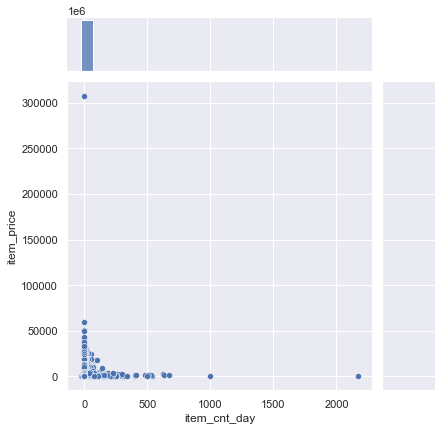

In [33]:
sns.jointplot('item_cnt_day', 'item_price', train, kind='scatter')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


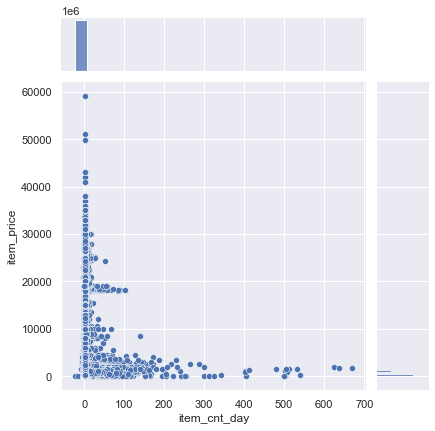

In [34]:
# 先过滤明显的离群值
train_filtered = train[(train['item_cnt_day'] < 800) & (train['item_price'] < 70000)].copy()
sns.jointplot('item_cnt_day', 'item_price', train_filtered, kind='scatter')

In [35]:
# 查看价格和销量的异常情况
outer = train[(train['item_cnt_day'] > 400) | (train['item_price'] > 40000)]
outer.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,17.09.2013,8,12,11365,59200.0,1.0
1006638,24.10.2013,9,12,7238,42000.0,1.0
1163158,13.12.2013,11,12,6066,307980.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0
1501160,15.03.2014,14,24,20949,5.0,405.0


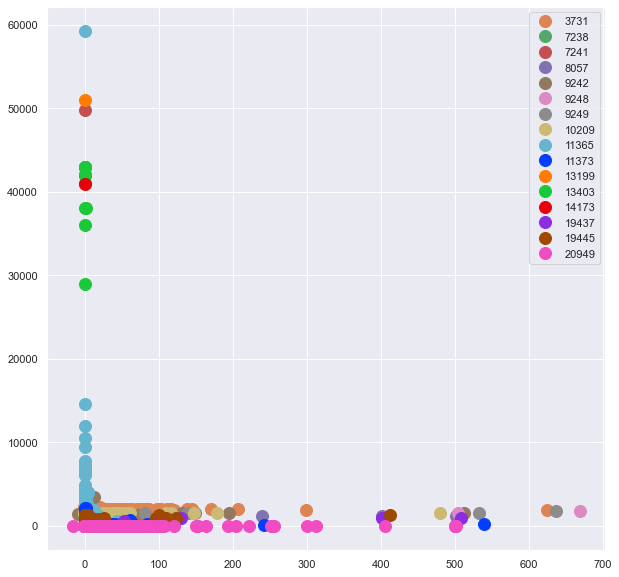

In [36]:
outer_set = train_filtered[train_filtered['item_id'].isin(outer['item_id'].unique())].groupby('item_id')
 
fig, ax = plt.subplots(1,1,figsize=(10, 10))
colors = sns.color_palette() + sns.color_palette('bright')  # 使用调色板。默认颜色只有10来种，会重复使用，不便于观察
i = 1
for name, group in outer_set:
    ax.plot(group['item_cnt_day'], group['item_price'], marker='o', linestyle='', ms=12, label=name, c=colors[i])
    i += 1
ax.legend()

plt.show()

上图可以看出:
1. 青蓝的11365、 橙色的13199 、深红的7241 出现了价格异常高的情况 （大于45000）。（价格在25000 到 45000 是否要考虑）
2. 浅粉的9248、灰色的9249、橘色的3731 出现了销量特别高的情况 （大于600）。（销量高于500的记录也大部分偏离较远，是否需要计入离群值的考量）

<AxesSubplot:>

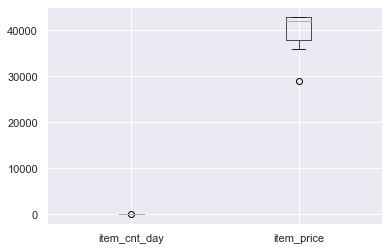

In [37]:
# 7238号和14173号只出现过一次，13403号则是新品， 可以考虑过滤掉7238号和214173号
train.loc[train['item_id']==13403].boxplot(['item_cnt_day', 'item_price'])

销量高于500的记录中， 蓝色11373和灰色9249的记录看起来明显离群，应该过滤。
剩下的大于400小于600之间的最大值是512。
再查看400到520这中间的商品的销量情况。 

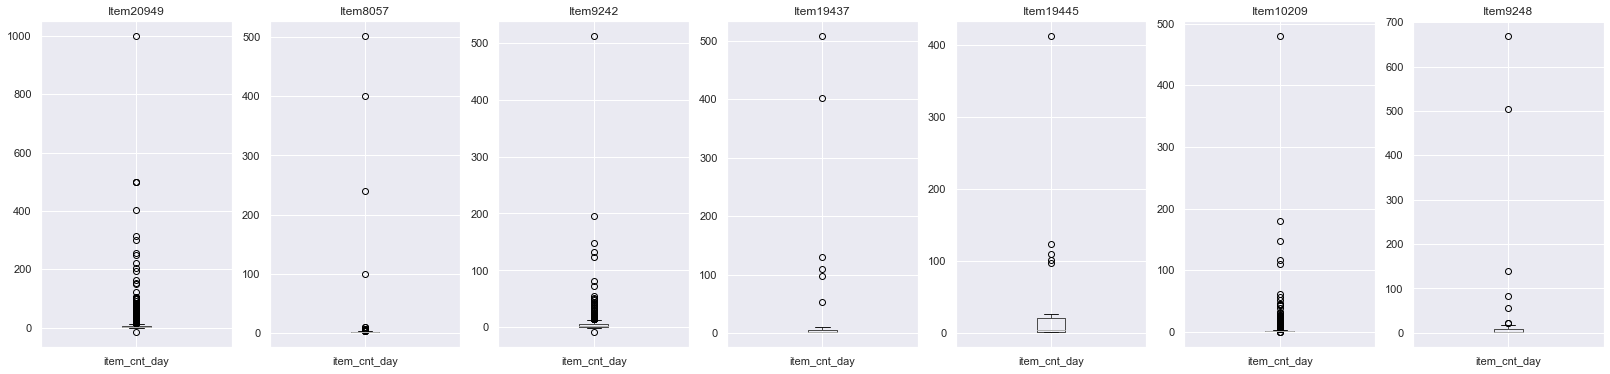

In [38]:
m_400 = train[(train['item_cnt_day'] > 400) & (train['item_cnt_day'] < 520)]['item_id'].unique()
n = m_400.size
fig, axes = plt.subplots(1,n,figsize=(n*4, 6))
for i in range(n):
    train[train['item_id'] == m_400[i]].boxplot(['item_cnt_day'], ax=axes[i])
    axes[i].set_title('Item%d' % m_400[i])
plt.show()

销量大于400的记录都偏离其总体水平较远。

总结：
过滤掉7238号和214173号，过滤掉单价高于45000的记录，过滤掉日销量高于400的记录 。
本该查看所有商品销量的离群值。但是数量太多了，耗时且不实际。暂且只过滤与总体差异较为显著的。
况且商品交易本身存在一定的不确定性，去掉全部异常，保留范围内的数据建立的理想化模型来模拟实际情况，结果可能适得其反。保留数据中可接受范围的噪声数据反而更符合实际情况。 

In [39]:
filtered = train[(train['item_cnt_day'] < 400) & (train['item_price'] < 45000)].copy()
filtered.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [40]:
filtered.drop(index=filtered[filtered['item_id'].isin([7238, 14173])].index, inplace=True)

In [41]:
del train, train_filtered
gc.collect()

55

训练集出现销量为-1的情况，估计是出现退货了，属于正常情况。
需要查看有没有小于0的id或者价格。 

In [42]:
(filtered[['date_block_num', 'shop_id','item_id', 'item_price']] < 0).any()

date_block_num    False
shop_id           False
item_id           False
item_price         True
dtype: bool

In [43]:
# 商品单价小于0的情况
filtered[filtered['item_price'] <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [44]:
filtered.groupby(['date_block_num','shop_id', 'item_id'])['item_price'].mean().loc[4, 32, 2973]

1249.0

In [45]:
filtered.loc[filtered['item_price'] <= 0, 'item_price'] = 1249.0  # 用了同一个月同一个商店该商品的均价
filtered[filtered['item_price'] <= 0]  # 检查是否替换成功

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [46]:
# 下面也给出替换的函数
def clean_by_mean(df, keys, col):
    """
    用同一月份的均值替换小于等于0的值
    keys 分组键；col 需要替换的字段
    """
    group = df[df[col] <= 0]
    # group = df[df['item_price'] <= 0]
    mean_price = df.groupby(keys)[col].mean()
    # mean_price = df.groupby(['date_block_num', 'shop_id', 'item_id'])['item_price'].mean()
    for i, row in group.iterrows:
        record = group.loc[i]
        df.loc[i,col] = mean_price.loc[record[keys[0]], record[keys[1]], record[keys[2]]]
        # df.loc[i,'item_price'] = mean_price.loc[record['date_block_num'], record['shop_id'], record['item_id']]
    return df

## 数据规整 和 数据分析（EDA）

In [47]:
# 添加日营业额
filtered['turnover_day'] = filtered['item_price'] * filtered['item_cnt_day']
filtered.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,turnover_day
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


### 销量分析

In [48]:
item_sales_monthly = filtered.pivot_table(columns='item_id',
                                          index='date_block_num', 
                                          values='item_cnt_day',
                                          fill_value=0,
                                          aggfunc=sum)
item_sales_monthly.head()

item_id,0,1,2,3,4,5,6,7,8,9,...,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
date_block_num,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,11,0,0,0,0,0,0,0,2,0
1,0,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,6,1,0,0,0,0,0,0,0,0


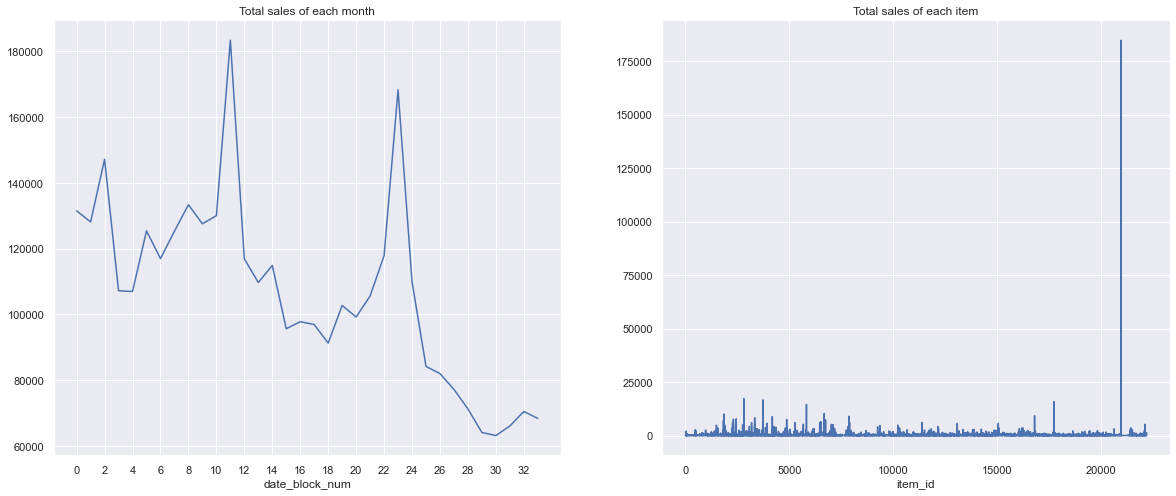

In [49]:
fig, axes = plt.subplots(1,2, figsize=(20, 8))

item_sales_monthly.sum(1).plot(ax=axes[0], title='Total sales of each month', xticks=[i for i in range(0,34,2)])  # 每月总销量
item_sales_monthly.sum(0).plot(ax=axes[1], title='Total sales of each item')  # 每个商品的总销量
plt.subplots_adjust(wspace=0.2)

描述：
总体销量出现下滑趋势，且每月销量大部分都同比下降。
有一款商品的销量异常高。

In [50]:
top_sales = item_sales_monthly.sum().sort_values(ascending=False)
top_sales

item_id
20949    184736
2808      17245
3732      16642
17717     15830
5822      14515
          ...  
7547          0
13474        -1
18062        -1
11871        -1
1590        -11
Length: 21796, dtype: int64

In [51]:
test[test['item_id'].isin(top_sales[top_sales<=0].index)]

,ID,shop_id,item_id


### 销量最高的商品

In [52]:
top_sales.iloc[0] / item_sales_monthly.sum().sum() * 100  # 销量占比

5.0801850069973

<AxesSubplot:xlabel='date_block_num'>

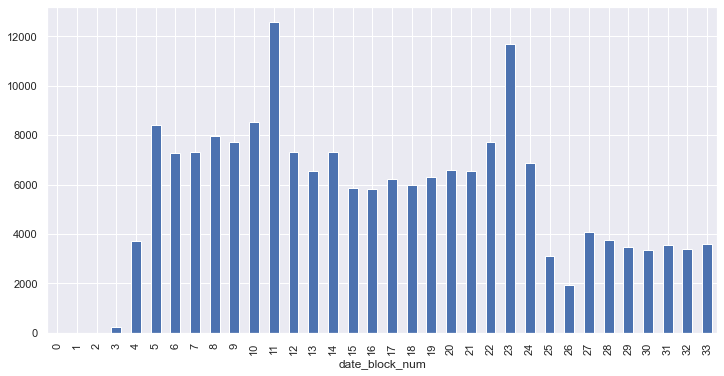

In [53]:
item_sales_monthly[top_sales.index[0]].plot(kind='bar', figsize=(12,6))  # 每月销量

In [54]:
item_turnover_monthly = filtered.pivot_table(index= 'date_block_num',
                                               columns= 'item_id',
                                               values='turnover_day',
                                               fill_value=0,
                                               aggfunc=sum)
item_turnover_monthly.head()

item_id,0,1,2,3,4,5,6,7,8,9,...,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
date_block_num,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,1477,0,0.0,0.0,0.0,0,0,0.0,1598.0,0
1,0,0,0,0,0,0,0,0,0,0,...,962,0,0.0,0.0,0.0,0,0,0.0,1598.0,0
2,0,0,0,0,0,0,0,0,0,0,...,894,0,0.0,0.0,0.0,0,0,0.0,798.5,0
3,0,0,0,0,0,0,0,0,0,0,...,298,0,0.0,0.0,0.0,0,0,0.0,0.0,0
4,0,0,0,0,0,0,0,0,0,0,...,894,58,0.0,0.0,0.0,0,0,0.0,0.0,0


In [55]:
item_sales_monthly = item_sales_monthly.drop(columns=top_sales[top_sales<=0].index, axis=1)  # 去掉销量为0和负值的商品
item_turnover_monthly = item_turnover_monthly.drop(columns=top_sales[top_sales<=0].index, axis=1)

In [56]:
total_turnover = item_turnover_monthly.sum().sum()
item_turnover_monthly[top_sales.index[0]].sum() / total_turnover * 100

0.02703470087824863

在总销量排名第一的商品，其总销量占到所有总销量的5.080%，但是其总营收却只占到了所有商品总营收的0.027%

In [57]:
items[items['item_id']==20949]

,item_name,item_id,item_category_id,item_type_code,sub_type_code
20949,Фирменныйпакетмайка1СИнтересбелый(34*42)45мкм,20949,71,13,54


翻译过来是一种打包用的包装。该商品的销量依赖于其他需要包装的商品的销售情况。

该产品出现月销量总体下降的情况，说明相应依赖的商品也是总体销量呈下降的趋势。

### 分析总体销量呈现下降趋势可能存在的原因

使该公司月销量出现总体下降的原因可能存在于两个方面：

一是：商店商品本身热度或生命名周期，等商品内在相关因素，使得商品销量减少。

二是：商品下架或者缺货等外在原因导致商品不再销售，从而影响商品销量。

这两方面的因素不是孤立存在的，对于总体销量来说，这两个影响因素往往是同时存在的。 

<AxesSubplot:xlabel='date_block_num'>

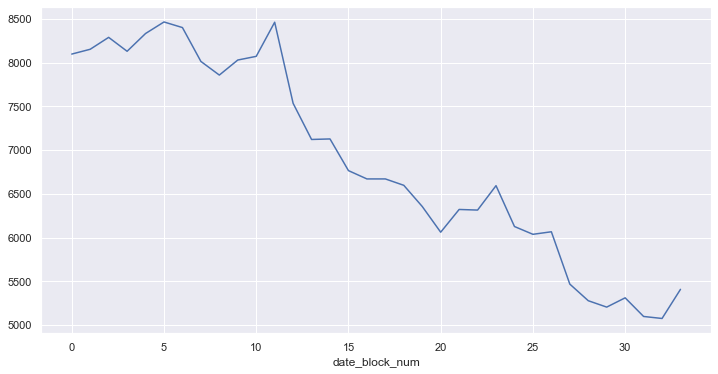

In [58]:
(item_sales_monthly > 0).sum(1).plot(figsize=(12, 6))

2013年每个月在有销量的商品的数量（在售商品数量）都在7500个以上。
2014年每月有销量的商品下降到了约7500-6000个。
2015年则下降到约6500-500个。

小结：在售商品数量呈现总体持续下降的趋势。 

<AxesSubplot:xlabel='date_block_num'>

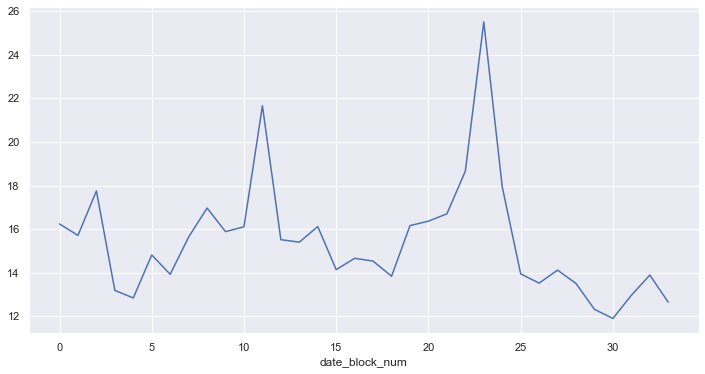

In [59]:
item_sales_monthly.sum(1).div((item_sales_monthly > 0).sum(1)).plot(figsize=(12, 6))
# 商品月总销量 / 当月在售商品数量 = 当月在售商品平均销量

小结：2013年和2014年在售商品月平均销量基本都在13-16个，2015年的在售商品月平均销量则下降到12-14个。

结论：
商品丰富度下降是导致总体销量呈现下降趋势的主要因素之一。
除此之外，2015年在售商品的月均销量相比2013年和2014年下降有所下降，使得2015年总体销量下降幅度高于2013年和2014年。

## 营收分析

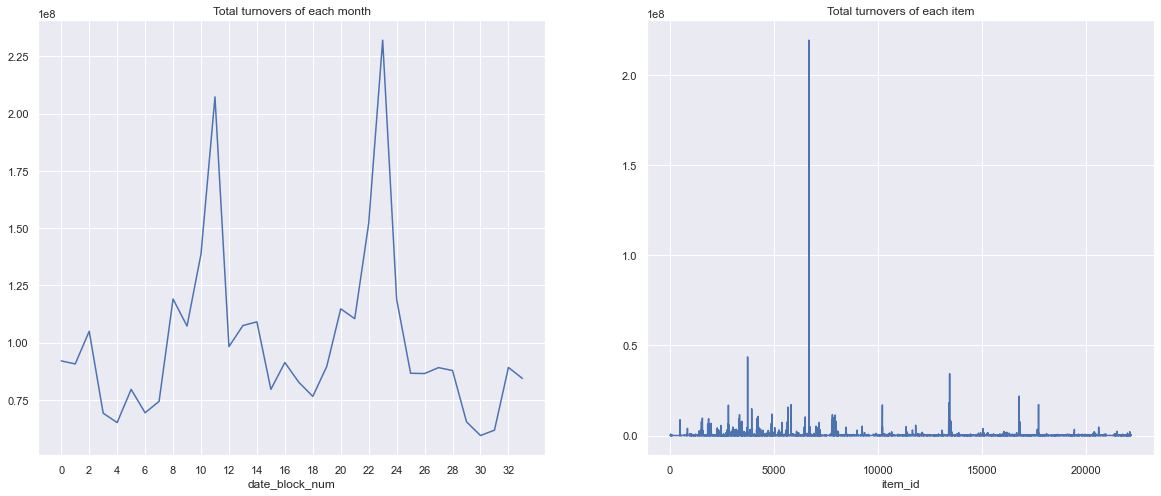

In [60]:
fig, axes = plt.subplots(1,2, figsize=(20, 8))
item_turnover_monthly.sum(1).plot(ax=axes[0], title='Total turnovers of each month', xticks=[i for i in range(0,34,2)])  # 每月总营收
item_turnover_monthly.sum(0).plot(ax=axes[1], title='Total turnovers of each item')  # 每个商品的总营收
plt.subplots_adjust(wspace=0.2)

描述：
第23个月份的营业收入比第11个月同增长明显，而在销量方面则是同比下跌的。
有一款商品的总营业收入异常的高。 

### 总营收最高的商品

In [61]:
top_turnover = item_turnover_monthly.sum().sort_values(ascending=False)
top_turnover

item_id
6675     2.193915e+08
3732     4.361798e+07
13443    3.433125e+07
3734     3.106516e+07
3733     2.229886e+07
             ...     
18098    2.100000e+01
3856     1.700000e+01
7756     1.500000e+01
22010    1.400000e+01
22098    7.000000e+00
Length: 21788, dtype: float64

In [62]:
item_turnover_monthly[top_turnover.index[0]].sum() / total_turnover * 100

6.472732889978659

In [63]:
item_sales_monthly[top_turnover.index[0]].sum() / item_sales_monthly.sum().sum() * 100

0.2829433478063709

在总营业收入排名第一的商品，其销量占总销量的0.28%，其营业收入占公司总营业收入的6.47% 。

<AxesSubplot:xlabel='date_block_num'>

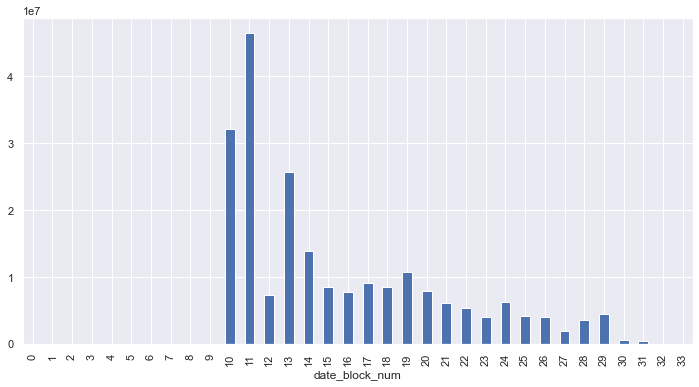

In [64]:
item_turnover_monthly[top_turnover.index[0]].plot(kind='bar', figsize=(12, 6))

<AxesSubplot:xlabel='date_block_num'>

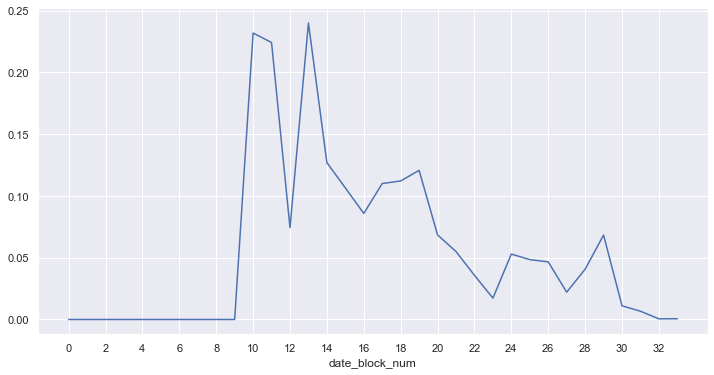

In [65]:
item_turnover_monthly[top_turnover.index[0]].div(item_turnover_monthly.sum(1)).plot(figsize=(12, 6),xticks=[i for i in range(0,34,2)])

In [66]:
items[items['item_id']==top_turnover.index[0]]

,item_name,item_id,item_category_id,item_type_code,sub_type_code
6675,SonyPlayStation4(500Gb)Black(CUH-1008A/1108A/B01),6675,12,4,3


这是一款索尼PS4游戏机的一个型号，在13年11月份开始销售，营业收入最的月份为2013年12月，占当月公司总营业收入比例约23%。在15年最后2个月已经没有销量了。

## 分析导致14年底销量和营收同比增长趋势不一致的可能原因

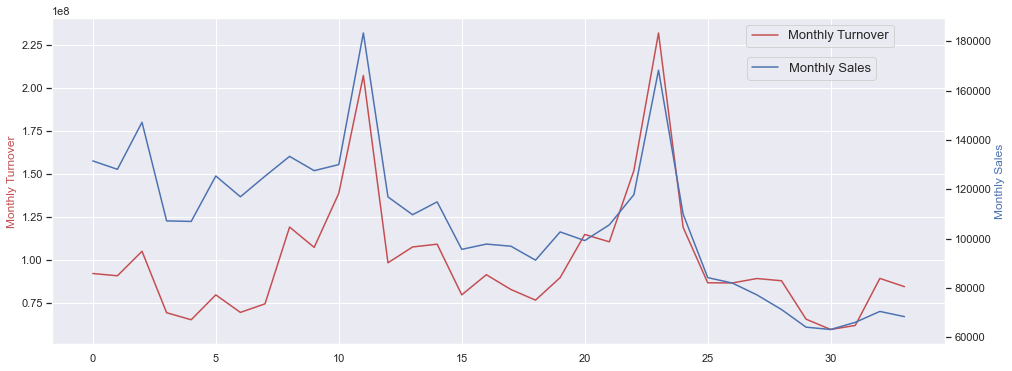

In [67]:
turnover_monthly = item_turnover_monthly.sum(1)
sales_monthly = item_sales_monthly.sum(1)
fig, axe1 = plt.subplots(1, 1, figsize=(16, 6))
axe2 = axe1.twinx()
axe1.plot(turnover_monthly.index, turnover_monthly.values, c='r')

axe2.plot(sales_monthly.index, sales_monthly.values, c='b')
axe2.grid(c='c', alpha=0.3)
axe1.legend(['Monthly Turnover'],fontsize=13, bbox_to_anchor=(0.95, 1))
axe2.legend(['Monthly Sales'],fontsize=13, bbox_to_anchor=(0.93, 0.9))
axe1.set_ylabel('Monthly Turnover', c='r')
axe2.set_ylabel('Monthly Sales', c='b')
plt.show()

In [69]:
sales_growth = item_sales_monthly.loc[23].sum() - item_sales_monthly.loc[11].sum()
sales_growth_rate = sales_growth / item_sales_monthly.loc[11].sum() * 100
turnover_growth = item_turnover_monthly.loc[23].sum() - item_turnover_monthly.loc[11].sum()
turnover_growth_rate = turnover_growth / item_turnover_monthly.loc[11].sum() * 100
print(
    ' 销售同比增长量为： %.2f ，同比增长率为： %.2f%%;\n' % (sales_growth, sales_growth_rate),
    '营收同比增长量为： %.2f ，同比增长率为： %.2f%%。' % (turnover_growth, turnover_growth_rate)
     )

 销售同比增长量为： -15086.00 ，同比增长率为： -8.23%;
 营收同比增长量为： 24759419.35 ，同比增长率为： 11.95%。


第23月（2014年12月）销量同比第11月（2013年12月）下降了约15000，但是第23月营业收入同比第11月反而上涨了2500000。
同比增长比率为：销量同比下降8.23%，营业收入同比上涨11.95%。 

In [70]:
dec_set = item_turnover_monthly.loc[[11, 23]]
dec_set

item_id,0,1,2,3,4,5,6,7,8,9,...,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
date_block_num,,,,,,,,,,,,,,,,,,,,,
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0,4800,24613.2,0.0,0
23,0,0,0,0,0,28,0,28,0,0,...,0,0,0.0,0.0,0.0,0,1650,11960.0,0.0,0


In [78]:
# 观察这两个月份营业收入的分布情况:
plt.figure(figsize=(8, 4))
sns.boxenplot(x=dec_set.item_id)

AttributeError: 'DataFrame' object has no attribute 'item_id'

<Figure size 576x288 with 0 Axes>

In [79]:
# 有三款商品的营业收入明显高于其他商品
dec_top = dec_set.loc[:,dec_set.sum() > 5000000]
dec_top  # 年底营收最高的商品

item_id,6675,13405,13443
date_block_num,,,
11,4.645973e+07,0.000000e+00,0.0
23,4.014789e+06,7.906979e+06,24203004.2


在2013年或2014年年底营业收入远超其他商品的商品中，13405号和13443号商品只出现在2014年年底。

可以从新增的这两款商品对营收影响这方面着手分析。

In [80]:
dec_top.iloc[1, 1:].sum() / dec_set.iloc[1].sum() * 100  # 只在第23月出售的商品其营业额占第23个月所有商品营业额的百分比

13.839127677594432

In [81]:
item_sales_monthly.loc[23,dec_top.columns[1:]].sum() / item_sales_monthly.loc[23].sum() * 100
# 13405和13443号商品在第23月销量之和与所有商品总销量的百分比

0.8701078719800304

13405号和13443号商品在2014年12月的营业收入占该月所有商品营业收入的约13.84%，而该月销量只占该月所有总销量的0.87%。

In [82]:
(dec_set.iloc[1].sum() - dec_set.iloc[0].sum()) / dec_set.iloc[0].sum() * 100  # 同比增长率

11.945851204367324

In [83]:
(dec_set.iloc[1].sum() - dec_set.iloc[0].sum()) / dec_set.iloc[1].sum() * 100  # 增长量占总额的百分比

10.67109774578344

<AxesSubplot:xlabel='date_block_num'>

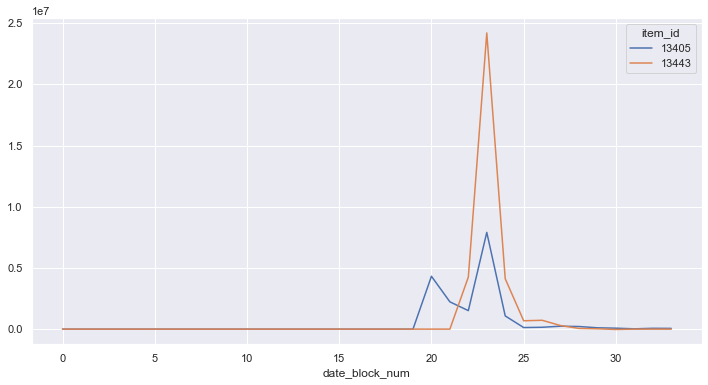

In [84]:
item_turnover_monthly[dec_top.columns[1:]].plot(figsize=(12, 6))

该公司14年12月份营业收入同比增长11.94%,同比增长量占总量10.67%。
而13405号和13443号商品在2014年12月的营业收入占该月所有商品营业收入的约13.84%，超过增长量。

结论：
13405号和13443号商品是该公司14年12月份营业收入同比大幅度增长的主要因素之一。
此外，在前面分析6675号商品中，该商品在2013年12月营收占比约为23%，在2014年的营收占比下降到了约为3%。说明2014年还有其他商品贡献了这约为20%的营业收入。 

## 帕累托贡献度分析

In [85]:
item_turnover_prop_cumsum = item_turnover_monthly.sum().div(total_turnover).sort_values(ascending=False).cumsum()
pct80 = item_turnover_prop_cumsum.searchsorted(0.8) + 1
pct80_items = item_turnover_prop_cumsum.iloc[:pct80].index
pct80_items

Int64Index([ 6675,  3732, 13443,  3734,  3733, 16787,  3731, 13405, 17717,
             5823,
            ...
             7073, 14333, 15240, 15450,  5581,  3458,  2040,  4837,  1515,
            20658],
           dtype='int64', name='item_id', length=1678)

In [86]:
sales_pct = item_sales_monthly[pct80_items].sum().sum()/ item_sales_monthly.sum().sum()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24635 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 33829 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25910 missing from current font.
  font.set_tex

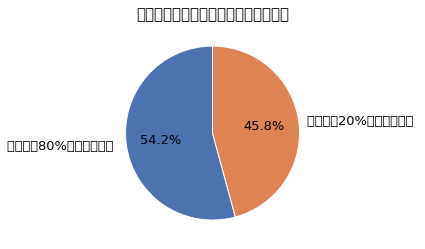

In [87]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.pie([sales_pct, 1 - sales_pct],
        labels=['占总营收80%的商品总销量 ', '占总营收20%的商品总销量 '],
       autopct="%.1f%%",
       textprops={'fontsize':13,'color':"black"}, 
        startangle=90)
plt.title('帕累托贡献度分析：销量对营收的贡献', fontdict={'fontsize':15,'color':"black"})
plt.show() 

小结： 54.2%的商品销量产生了80%的营收效益。45.8%的商品销量只产生了20%的效益。

## 店铺对营业收入的贡献

<AxesSubplot:xlabel='shop_id'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


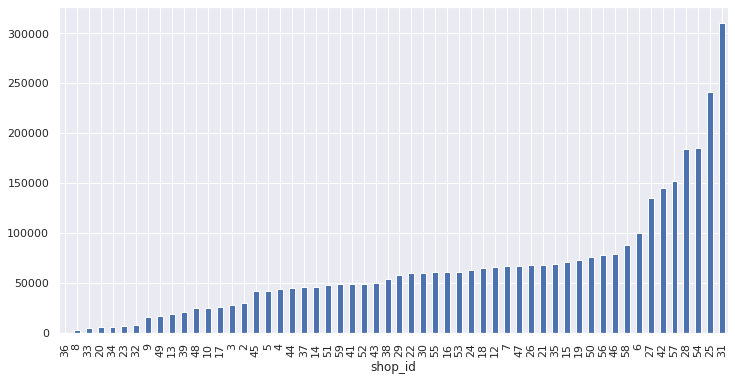

In [88]:
filtered.groupby('shop_id')['item_cnt_day'].sum().sort_values().plot(kind='bar', figsize=(12, 6))

<AxesSubplot:xlabel='shop_id'>

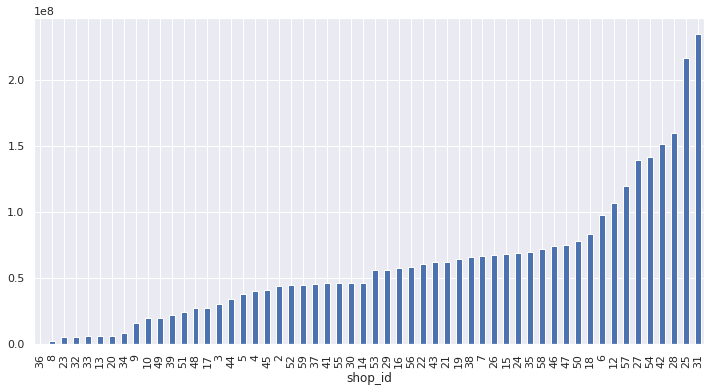

In [89]:
filtered.groupby('shop_id')['turnover_day'].sum().sort_values().plot(kind='bar', figsize=(12, 6))

In [90]:
# 对总销量贡献的前三个商店分别是31、25、54号。28号的销量与54号相差不大。
# 对总营业收费贡献的前三个商店分别是31、25、28号。
shops[shops['shop_id'].isin([31, 25, 54, 28])]

,shop_name,shop_id,shop_city,shop_type,shop_city_code,shop_type_code
25,"Москва ТРК ""Атриум""",25,Москва,ТРК,14,2
28,"Москва ТЦ ""МЕГА Теплый Стан"" II",28,Москва,ТЦ,14,1
31,"Москва ТЦ ""Семеновский""",31,Москва,ТЦ,14,1
54,"Химки ТЦ ""Мега""",54,Химки,ТЦ,27,1


小结：

对总销量和总营业收入贡献前三名的商店都来自同一个城市。

Москва 即：莫斯科，是俄罗斯联邦首都、莫斯科州首府，Химки也是来自莫斯科州，莫斯科州GDP占俄罗斯全国GDP的1/3。

商店所在城市的经济规模在很大程度上影响了商店的商品销量。 

## 产品种类对营业收入的贡献

In [91]:
filtered = filtered.merge(items.iloc[:,1:], on='item_id', how='left')
filtered.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,turnover_day,item_category_id,item_type_code,sub_type_code
0,02.01.2013,0,59,22154,999.00,1.0,999.00,37,10,21
1,03.01.2013,0,25,2552,899.00,1.0,899.00,58,12,41
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00,58,12,41
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05,58,12,41
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00,56,12,39


<AxesSubplot:xlabel='item_category_id'>

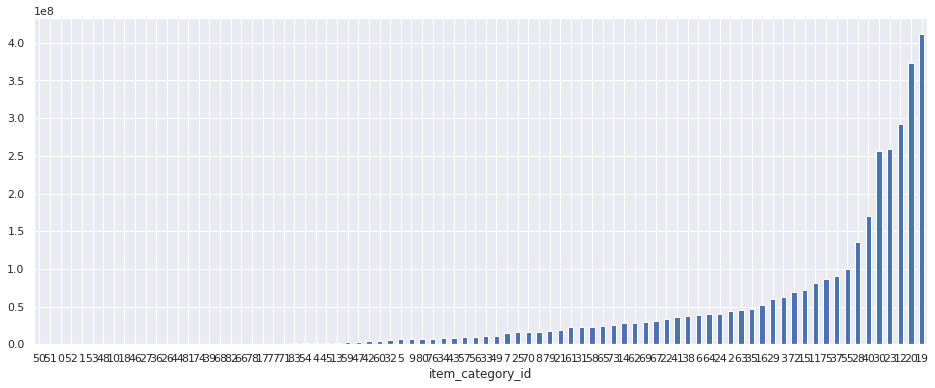

In [92]:
filtered.groupby('item_category_id')['turnover_day'].sum().sort_values().plot(kind='bar',figsize=(16,6), rot=0)

<AxesSubplot:xlabel='item_type_code'>

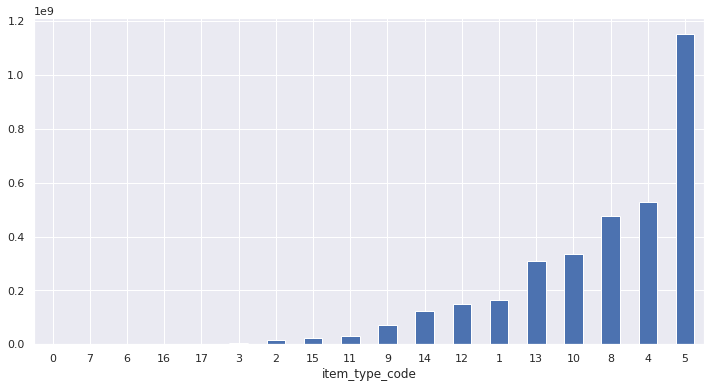

In [93]:
filtered.groupby('item_type_code')['turnover_day'].sum().sort_values().plot(kind='bar',figsize=(12,6), rot=0)

<AxesSubplot:xlabel='sub_type_code'>

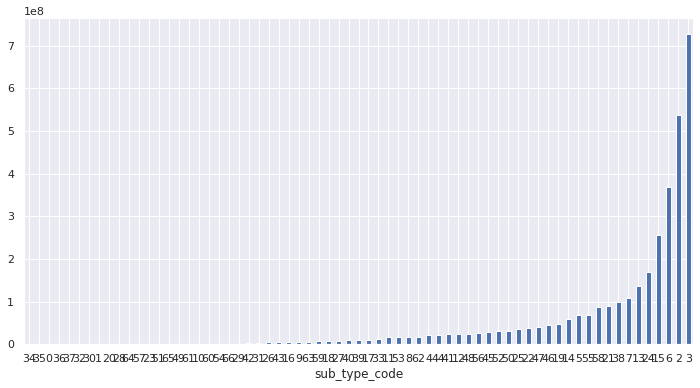

In [94]:
filtered.groupby('sub_type_code')['turnover_day'].sum().sort_values().plot(kind='bar',figsize=(12,6), rot=0)

小结：
- 商品类目中对总营业收入贡献最大的前三类分别是第19、20、12类。
- 商品大类中第5类商品对总营业收入贡献最大，且与其他类差异明显。
- 商品小类中对总营业收入贡献最大的前三类分别是第3、2、6类。

<AxesSubplot:xlabel='item_category_id'>

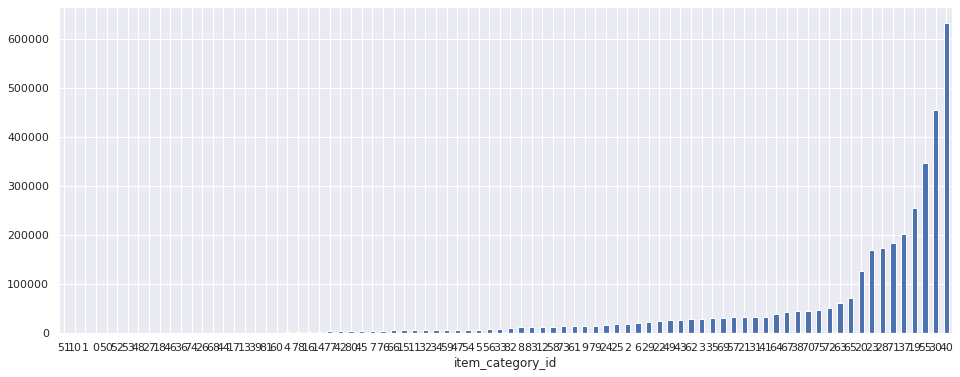

In [95]:
filtered.groupby('item_category_id')['item_cnt_day'].sum().sort_values().plot(kind='bar',figsize=(16,6), rot=0)

<AxesSubplot:xlabel='item_type_code'>

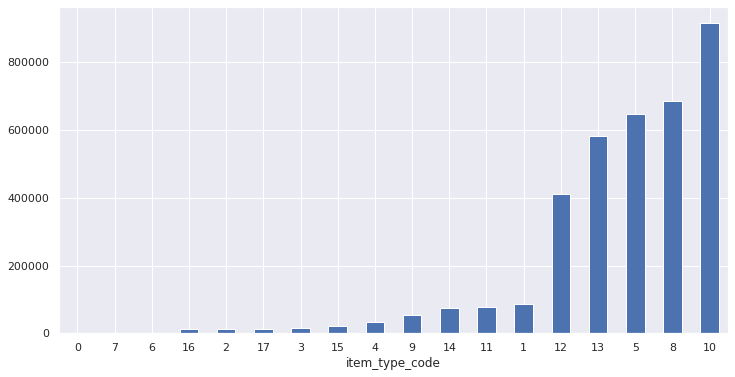

In [96]:
filtered.groupby('item_type_code')['item_cnt_day'].sum().sort_values().plot(kind='bar',figsize=(12,6), rot=0)

<AxesSubplot:xlabel='sub_type_code'>

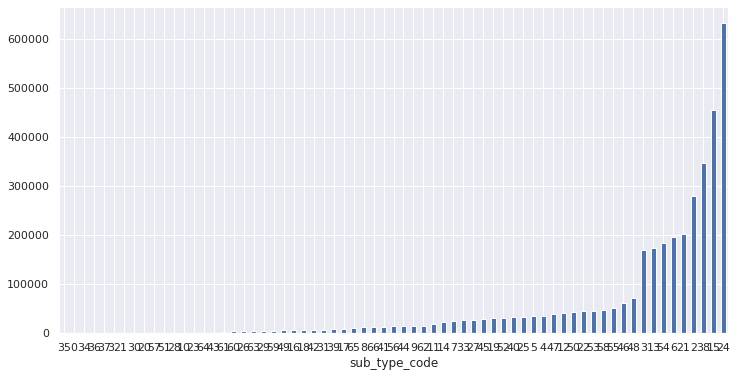

In [97]:
filtered.groupby('sub_type_code')['item_cnt_day'].sum().sort_values().plot(kind='bar',figsize=(12,6), rot=0)

小结：

    商品类目中对总销量贡献最大的前三类分别是第40、30、55类。
    商品大类中对总销量贡献最大的前三类分别是第10、8、5类，
    商品小类中对总销量贡献最大的前三类分别是第24、15、38类。

    在商品大类销量与营业收入综合贡献中，影响最大的是第5和第8类。
    在商品类目和商品小类中销量和营收前三名中，没有出现重叠的情况。没有综合贡献突出的类。

* 不同种类的商品存在较为明显的销量差异。

## 城市和商店类型对营业收入的贡献

In [98]:
filtered = filtered.merge(shops[['shop_id','shop_city_code','shop_type_code']], on='shop_id', how='left')
filtered.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,turnover_day,item_category_id,item_type_code,sub_type_code,shop_city_code,shop_type_code
0,02.01.2013,0,59,22154,999.00,1.0,999.00,37,10,21,29,1
1,03.01.2013,0,25,2552,899.00,1.0,899.00,58,12,41,14,2
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00,58,12,41,14,2
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05,58,12,41,14,2
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00,56,12,39,14,2


<AxesSubplot:xlabel='shop_city_code'>

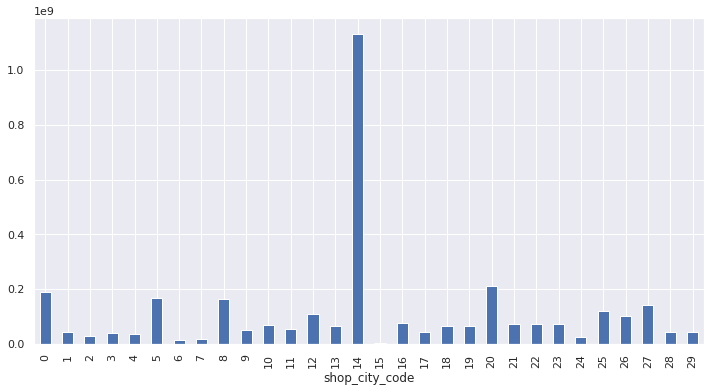

In [99]:
filtered.groupby('shop_city_code')['turnover_day'].sum().plot(kind='bar',figsize=(12,6))

<AxesSubplot:xlabel='shop_type_code'>

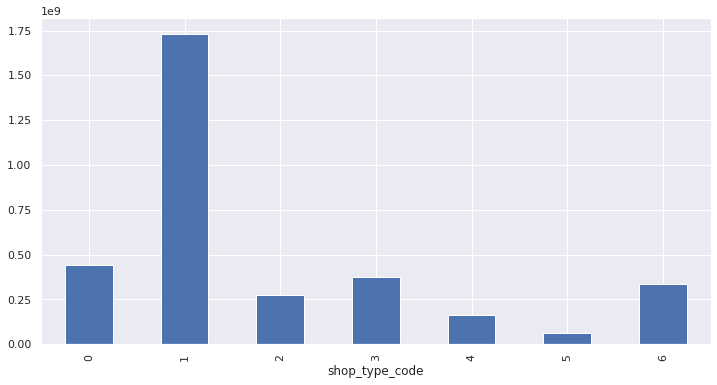

In [100]:
filtered.groupby('shop_type_code')['turnover_day'].sum().plot(kind='bar',figsize=(12,6))

 小结： 14区城市的商店对总营业收入贡献最大。1类商店对总营业收入贡献最大

<AxesSubplot:xlabel='shop_city_code'>

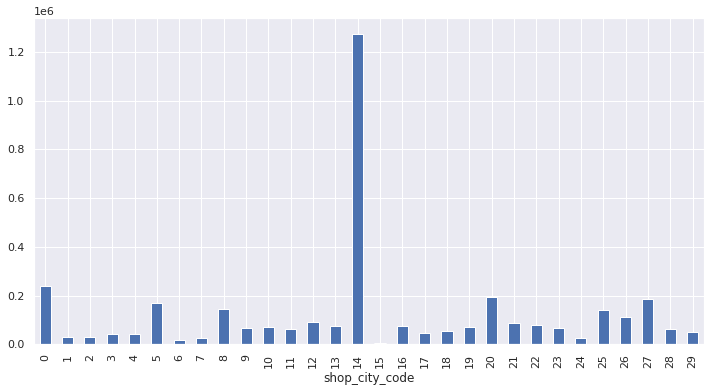

In [101]:
filtered.groupby('shop_city_code')['item_cnt_day'].sum().plot(kind='bar',figsize=(12,6))

<AxesSubplot:xlabel='shop_type_code'>

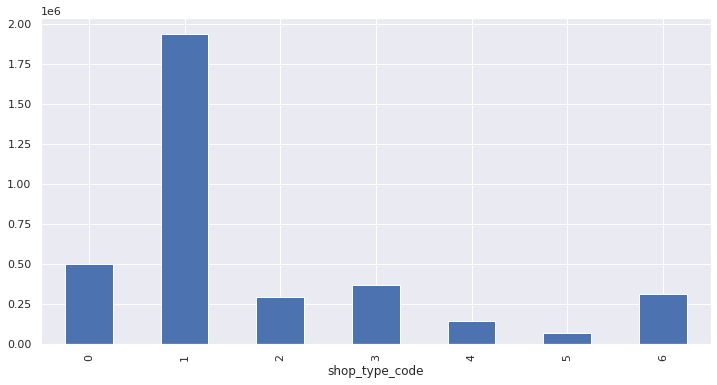

In [102]:
filtered.groupby('shop_type_code')['item_cnt_day'].sum().plot(kind='bar',figsize=(12,6))

小结：

    在销量方面也是14区城市的商店和1类商店贡献最大。
    主要影响因素是总营收和总销量排名前三的商店都在14区城市。

* 除了前面分析的商店所在城市会影响商品销量，商店的规模同样在较大程度上影响了商品销量。

题外话:
在查阅别人的方案时，看到的几乎是直接跳过对这些特征的分析的过程，只给出哪些特征是有用的，容易让人不明所以。通过观测这些特征的值的分布情况，可以直观地了解不同特征对结果影响程度的差异。
而且在后面特征重要性画图时，这些特征的重要性和特征本身对结果影响程度两者之间的一致性，可以作为特征选择可靠性的评判参考。

## 预测未来销量

### 处理关闭的商店和停售的商品

In [103]:
shop_sales_monthly = filtered.pivot_table(index='date_block_num',
                                          columns='shop_id',
                                          values='item_cnt_day',
                                          fill_value=0,
                                          aggfunc=sum)
shop_open_month_cnt = (shop_sales_monthly.iloc[-6:] >  0).sum()  # 有销量的记录
shop_open_month_cnt.head()  # 每个店铺最后半年里有几个月有销量

shop_id
2    6
3    6
4    6
5    6
6    6
dtype: int64

In [104]:
shop_c_n = shop_sales_monthly[shop_open_month_cnt[shop_open_month_cnt < 6].index]
shop_c_n.tail(12)
# 最后半年经营月数少于6个月的店铺

shop_id,8,9,13,17,20,23,27,29,30,32,33,36,43,51,54
date_block_num,,,,,,,,,,,,,,,
22,0,0,0,1199,0,0,4675,1926,2044,0,814,0,2659,1090,6389
23,0,0,0,1832,0,0,7896,2402,2700,0,1056,0,3139,1652,7677
24,0,0,0,689,0,0,5660,1564,1842,0,1006,0,1340,976,6043
25,0,0,0,0,0,0,3839,1273,745,0,792,0,0,660,4221
26,0,0,0,0,0,0,3634,1239,0,0,505,0,0,545,4625
27,0,-1,0,0,0,0,3518,1216,0,0,-1,0,0,494,732
28,0,0,0,0,0,0,3786,880,0,0,0,0,0,758,0
29,0,0,0,0,0,0,3357,0,0,0,0,0,0,659,0
30,0,0,0,0,0,0,2478,0,0,0,0,0,0,748,0


 9, 20, 36 当作是新店，其他的当作已经关闭了 

In [105]:
open_shop = shop_sales_monthly[shop_open_month_cnt[shop_open_month_cnt == 6].index]
open_shop.tail(7) # 最后半年都正常经营的商店

shop_id,2,3,4,5,6,7,10,12,14,15,...,48,49,50,52,53,55,56,57,58,59
date_block_num,,,,,,,,,,,,,,,,,,,,,
27,859,740,899,1054,1998,1340,594,2620,1055,1364,...,1081,542,895,1152,1322,3422,1237,2860,1710,1054
28,843,731,893,1012,1748,1217,466,2930,933,1277,...,1110,692,1073,894,1206,2117,1315,2408,1378,916
29,804,672,793,954,1539,1235,441,1830,1019,1332,...,990,789,900,820,1078,1909,1566,2440,1554,913
30,785,535,842,991,1484,1327,449,1554,954,1316,...,1102,856,1126,828,1257,1658,1491,2352,1689,992
31,942,666,947,1294,1575,1409,442,1471,1061,1360,...,1308,966,1081,932,1318,1976,1604,2780,1738,1214
32,822,745,732,1092,1725,1287,519,4042,1094,1267,...,1101,567,906,1086,1229,5697,1194,2266,1319,914
33,727,613,831,1052,1802,1212,428,1512,1002,1243,...,1111,648,949,847,1061,1972,1263,2316,1446,790


In [106]:
item_selling_month_cnt = (item_sales_monthly.iloc[-6:] >  0).sum() 
item_selling_month_cnt.head()  # 这些商品在最后半年有几个月有销量

item_id
0    0
1    0
2    0
3    0
4    0
dtype: int64

In [107]:
item_zero = item_sales_monthly[item_selling_month_cnt[item_selling_month_cnt == 0].index]
# 这些商品在最后半年都没有销量
item_zero.tail(12)

item_id,0,1,2,3,4,5,6,7,8,9,...,22150,22151,22152,22156,22157,22160,22161,22165,22168,22169
date_block_num,,,,,,,,,,,,,,,,,,,,,
22,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
selling_item = item_sales_monthly[item_selling_month_cnt[item_selling_month_cnt > 0].index]
selling_item.tail(12)  # 最后半年有销量的商品

item_id,30,31,32,33,38,39,40,42,45,49,...,22153,22154,22155,22158,22159,22162,22163,22164,22166,22167
date_block_num,,,,,,,,,,,,,,,,,,,,,
22,13,11,29,20,10,0,1,3,8,3,...,0,0,0,0,0,0,0,0,16,49
23,16,18,40,21,11,0,5,2,10,2,...,1,0,0,0,0,0,0,0,11,40
24,14,25,42,19,7,0,1,2,11,2,...,0,0,0,0,0,0,0,0,7,33
25,14,13,32,26,4,1,1,1,2,4,...,1,0,0,0,0,311,0,289,8,46
26,5,12,40,20,1,0,0,2,3,2,...,0,0,0,0,0,194,0,92,12,40
27,4,13,20,13,0,0,1,1,5,5,...,0,0,0,0,0,78,0,27,4,38
28,5,5,20,12,3,0,0,2,2,2,...,0,0,0,0,12,35,0,23,8,31
29,4,10,26,11,2,0,0,1,1,3,...,0,0,1,0,3,22,0,6,10,33
30,4,6,21,15,5,0,0,1,3,4,...,0,8,0,0,0,27,0,12,8,34


### 处理训练集
只保留最后6个月正常经营的商店和有销量的商品

In [109]:
cl_set = filtered[filtered['shop_id'].isin(open_shop.columns) & filtered['item_id'].isin(selling_item.columns)]
cl_set

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,turnover_day,item_category_id,item_type_code,sub_type_code,shop_city_code,shop_type_code
0,02.01.2013,0,59,22154,999.0,1.0,999.0,37,10,21,29,1
1,03.01.2013,0,25,2552,899.0,1.0,899.0,58,12,41,14,2
2,05.01.2013,0,25,2552,899.0,-1.0,-899.0,58,12,41,14,2
10,03.01.2013,0,25,2574,399.0,2.0,798.0,55,12,38,14,2
11,05.01.2013,0,25,2574,399.0,1.0,399.0,55,12,38,14,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2935819,10.10.2015,33,25,7409,299.0,1.0,299.0,55,12,38,14,2
2935820,09.10.2015,33,25,7460,299.0,1.0,299.0,55,12,38,14,2
2935821,14.10.2015,33,25,7459,349.0,1.0,349.0,55,12,38,14,2
2935822,22.10.2015,33,25,7440,299.0,1.0,299.0,57,12,40,14,2


In [110]:
#  统计月销量
from itertools import product
import time
ts = time.time()
martix = []
for i in range(34):
    record = cl_set[cl_set['date_block_num'] == i]
    group = product([i],record.shop_id.unique(),record.item_id.unique())
    martix.append(np.array(list(group)))
            
cols = ['date_block_num', 'shop_id', 'item_id']
martix = pd.DataFrame(np.vstack(martix), columns=cols)

martix

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2574
3,0,59,2607
4,0,59,2515
...,...,...,...
4940199,33,21,7635
4940200,33,21,7638
4940201,33,21,7640
4940202,33,21,7632


In [111]:
from itertools import product
import time
ts = time.time()
martix = []
for i in range(34):
    record = filtered[filtered['date_block_num'] == i]
    group = product([i],record.shop_id.unique(),record.item_id.unique())
    martix.append(np.array(list(group)))
            
cols = ['date_block_num', 'shop_id', 'item_id']
martix = pd.DataFrame(np.vstack(martix), columns=cols)

martix

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10840735,33,21,7635
10840736,33,21,7638
10840737,33,21,7640
10840738,33,21,7632


In [112]:
del cl_set
gc.collect()

31031

In [113]:
group = filtered.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': np.sum})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
1608242,33,59,22087,6.0
1608243,33,59,22088,2.0
1608244,33,59,22091,1.0
1608245,33,59,22100,1.0


In [114]:
martix = pd.merge(martix, group, on=['date_block_num', 'shop_id', 'item_id'], how='left')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN


测试集是第34月的数据，所以给测试集合添加上'date_block_num'字段并设置为34。
待预测的字段‘item_cnt_mun’就设置为0。 

In [115]:
test['date_block_num'] = 34
test['item_cnt_month'] = 0
martix = pd.concat([martix.fillna(0), test.drop(columns='ID')], sort=False, ignore_index=True, keys=['date_block_num','shop_id','item_id'])
martix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0
...,...,...,...,...
11054935,34,45,18454,0.0
11054936,34,45,16188,0.0
11054937,34,45,15757,0.0
11054938,34,45,19648,0.0


### 特征处理

#### 融合商店数据集和商品数据集的特征

In [116]:
martix = martix.merge(shops[['shop_id', 'shop_type_code', 'shop_city_code']], on='shop_id', how='left')
martix = martix.merge(items.drop(columns='item_name'), on='item_id', how='left')
martix

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code
0,0,59,22154,1.0,1,29,37,10,21
1,0,59,2552,0.0,1,29,58,12,41
2,0,59,2554,0.0,1,29,58,12,41
3,0,59,2555,0.0,1,29,56,12,39
4,0,59,2564,0.0,1,29,59,12,42
...,...,...,...,...,...,...,...,...,...
11054935,34,45,18454,0.0,1,21,55,12,38
11054936,34,45,16188,0.0,1,21,64,13,47
11054937,34,45,15757,0.0,1,21,55,12,38
11054938,34,45,19648,0.0,1,21,40,10,24


In [117]:
# 添加具体的年份和月份
martix['year'] =  martix['date_block_num'].map(lambda x: x // 12 + 2013)
martix['month'] = martix['date_block_num'].map(lambda x: x % 12)
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,month
0,0,59,22154,1.0,1,29,37,10,21,2013,0
1,0,59,2552,0.0,1,29,58,12,41,2013,0
2,0,59,2554,0.0,1,29,58,12,41,2013,0
3,0,59,2555,0.0,1,29,56,12,39,2013,0
4,0,59,2564,0.0,1,29,59,12,42,2013,0


#### 添加当月销量特征

In [118]:
# 当月商店、商品销量均值
# 商品 月销量均值
group = martix.groupby(['date_block_num','item_id']).agg({'item_cnt_month':'mean'})
group.columns = ['item_cnt_month_avg']
group.reset_index(inplace=True)
martix = martix.merge(group, on=['date_block_num', 'item_id'], how='left')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,month,item_cnt_month_avg
0,0,59,22154,1.0,1,29,37,10,21,2013,0,0.400000
1,0,59,2552,0.0,1,29,58,12,41,2013,0,0.000000
2,0,59,2554,0.0,1,29,58,12,41,2013,0,0.022222
3,0,59,2555,0.0,1,29,56,12,39,2013,0,0.044444
4,0,59,2564,0.0,1,29,59,12,42,2013,0,0.111111


In [119]:
# 商店 月销量均值
group = martix.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':'mean'})
group.columns = ['shop_cnt_month_avg']
group.reset_index(inplace=True)
martix = martix.merge(group, on=['date_block_num', 'shop_id'], how='left')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,month,item_cnt_month_avg,shop_cnt_month_avg
0,0,59,22154,1.0,1,29,37,10,21,2013,0,0.400000,0.248613
1,0,59,2552,0.0,1,29,58,12,41,2013,0,0.000000,0.248613
2,0,59,2554,0.0,1,29,58,12,41,2013,0,0.022222,0.248613
3,0,59,2555,0.0,1,29,56,12,39,2013,0,0.044444,0.248613
4,0,59,2564,0.0,1,29,59,12,42,2013,0,0.111111,0.248613


In [120]:
#  当月种类销量均值 
# 类别 月销量均值
group = martix.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':'mean'})
group.columns = ['cat_cnt_month_avg']
group.reset_index(inplace=True)
martix = martix.merge(group, on=['date_block_num', 'item_category_id'], how='left')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,month,item_cnt_month_avg,shop_cnt_month_avg,cat_cnt_month_avg
0,0,59,22154,1.0,1,29,37,10,21,2013,0,0.400000,0.248613,0.199738
1,0,59,2552,0.0,1,29,58,12,41,2013,0,0.000000,0.248613,0.043386
2,0,59,2554,0.0,1,29,58,12,41,2013,0,0.022222,0.248613,0.043386
3,0,59,2555,0.0,1,29,56,12,39,2013,0,0.044444,0.248613,0.049630
4,0,59,2564,0.0,1,29,59,12,42,2013,0,0.111111,0.248613,0.093842


In [121]:
# 商店-类别 月销量均值
group = martix.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month':'mean'})
group.columns = ['shop_cat_cnt_month_avg']
group.reset_index(inplace=True)
martix = martix.merge(group, on=['date_block_num','shop_id','item_category_id'], how='left')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,month,item_cnt_month_avg,shop_cnt_month_avg,cat_cnt_month_avg,shop_cat_cnt_month_avg
0,0,59,22154,1.0,1,29,37,10,21,2013,0,0.400000,0.248613,0.199738,0.088496
1,0,59,2552,0.0,1,29,58,12,41,2013,0,0.000000,0.248613,0.043386,0.000000
2,0,59,2554,0.0,1,29,58,12,41,2013,0,0.022222,0.248613,0.043386,0.000000
3,0,59,2555,0.0,1,29,56,12,39,2013,0,0.044444,0.248613,0.049630,0.008333
4,0,59,2564,0.0,1,29,59,12,42,2013,0,0.111111,0.248613,0.093842,0.012048


In [122]:
# 大类 月销量均值
group = martix.groupby(['date_block_num', 'item_type_code']).agg({'item_cnt_month':'mean'})
group.columns = ['itemtype_cnt_month_avg']
group.reset_index(inplace=True)
martix = martix.merge(group, on=['date_block_num', 'item_type_code'], how='left')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,month,item_cnt_month_avg,shop_cnt_month_avg,cat_cnt_month_avg,shop_cat_cnt_month_avg,itemtype_cnt_month_avg
0,0,59,22154,1.0,1,29,37,10,21,2013,0,0.400000,0.248613,0.199738,0.088496,0.284744
1,0,59,2552,0.0,1,29,58,12,41,2013,0,0.000000,0.248613,0.043386,0.000000,0.166607
2,0,59,2554,0.0,1,29,58,12,41,2013,0,0.022222,0.248613,0.043386,0.000000,0.166607
3,0,59,2555,0.0,1,29,56,12,39,2013,0,0.044444,0.248613,0.049630,0.008333,0.166607
4,0,59,2564,0.0,1,29,59,12,42,2013,0,0.111111,0.248613,0.093842,0.012048,0.166607


In [123]:
# 小类 月销量均值
group = martix.groupby(['date_block_num', 'sub_type_code']).agg({'item_cnt_month':'mean'})
group.columns = ['subtype_cnt_month_avg']
group.reset_index(inplace=True)
martix = martix.merge(group, on=['date_block_num','sub_type_code'], how='left')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,month,item_cnt_month_avg,shop_cnt_month_avg,cat_cnt_month_avg,shop_cat_cnt_month_avg,itemtype_cnt_month_avg,subtype_cnt_month_avg
0,0,59,22154,1.0,1,29,37,10,21,2013,0,0.400000,0.248613,0.199738,0.088496,0.284744,0.199738
1,0,59,2552,0.0,1,29,58,12,41,2013,0,0.000000,0.248613,0.043386,0.000000,0.166607,0.043386
2,0,59,2554,0.0,1,29,58,12,41,2013,0,0.022222,0.248613,0.043386,0.000000,0.166607,0.043386
3,0,59,2555,0.0,1,29,56,12,39,2013,0,0.044444,0.248613,0.049630,0.008333,0.166607,0.049630
4,0,59,2564,0.0,1,29,59,12,42,2013,0,0.111111,0.248613,0.093842,0.012048,0.166607,0.093842


In [124]:
#  当月商店城市和商店类型的销量均值 
# 城市-商品 月销量均值
group = martix.groupby(['date_block_num','shop_city_code','item_id']).agg({'item_cnt_month':'mean'})
group.columns = ['city_item_cnt_month_avg']
group.reset_index(inplace=True)
martix = martix.merge(group, on=['date_block_num','shop_city_code','item_id'], how='left')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,month,item_cnt_month_avg,shop_cnt_month_avg,cat_cnt_month_avg,shop_cat_cnt_month_avg,itemtype_cnt_month_avg,subtype_cnt_month_avg,city_item_cnt_month_avg
0,0,59,22154,1.0,1,29,37,10,21,2013,0,0.400000,0.248613,0.199738,0.088496,0.284744,0.199738,1.0
1,0,59,2552,0.0,1,29,58,12,41,2013,0,0.000000,0.248613,0.043386,0.000000,0.166607,0.043386,0.0
2,0,59,2554,0.0,1,29,58,12,41,2013,0,0.022222,0.248613,0.043386,0.000000,0.166607,0.043386,0.0
3,0,59,2555,0.0,1,29,56,12,39,2013,0,0.044444,0.248613,0.049630,0.008333,0.166607,0.049630,0.0
4,0,59,2564,0.0,1,29,59,12,42,2013,0,0.111111,0.248613,0.093842,0.012048,0.166607,0.093842,0.0


In [125]:
# 商店类型-商品 月销量均值
group = martix.groupby(['date_block_num','shop_type_code','item_id']).agg({'item_cnt_month':'mean'})
group.columns = ['shoptype_item_cnt_month_avg']
group.reset_index(inplace=True)
martix = martix.merge(group, on=['date_block_num','shop_type_code','item_id'], how='left')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,month,item_cnt_month_avg,shop_cnt_month_avg,cat_cnt_month_avg,shop_cat_cnt_month_avg,itemtype_cnt_month_avg,subtype_cnt_month_avg,city_item_cnt_month_avg,shoptype_item_cnt_month_avg
0,0,59,22154,1.0,1,29,37,10,21,2013,0,0.400000,0.248613,0.199738,0.088496,0.284744,0.199738,1.0,0.28
1,0,59,2552,0.0,1,29,58,12,41,2013,0,0.000000,0.248613,0.043386,0.000000,0.166607,0.043386,0.0,0.00
2,0,59,2554,0.0,1,29,58,12,41,2013,0,0.022222,0.248613,0.043386,0.000000,0.166607,0.043386,0.0,0.00
3,0,59,2555,0.0,1,29,56,12,39,2013,0,0.044444,0.248613,0.049630,0.008333,0.166607,0.049630,0.0,0.04
4,0,59,2564,0.0,1,29,59,12,42,2013,0,0.111111,0.248613,0.093842,0.012048,0.166607,0.093842,0.0,0.12


In [126]:
del group
gc.collect()

30

#### 添加销量特征的历史特征
本次项目目标是用历史销量数据预测未来销量。
所以在这里我们转换一下思路，用历史销量数据作为模型的特征，将本月销量结果作为标签建立模型进行回归分析。 

In [127]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [128]:
martix = lag_feature(martix, [1,2,3,6,12], 'item_cnt_month')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,...,shop_cat_cnt_month_avg,itemtype_cnt_month_avg,subtype_cnt_month_avg,city_item_cnt_month_avg,shoptype_item_cnt_month_avg,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,59,22154,1.0,1,29,37,10,21,2013,...,0.088496,0.284744,0.199738,1.0,0.28,NaN,NaN,NaN,NaN,NaN
1,0,59,2552,0.0,1,29,58,12,41,2013,...,0.000000,0.166607,0.043386,0.0,0.00,NaN,NaN,NaN,NaN,NaN
2,0,59,2554,0.0,1,29,58,12,41,2013,...,0.000000,0.166607,0.043386,0.0,0.00,NaN,NaN,NaN,NaN,NaN
3,0,59,2555,0.0,1,29,56,12,39,2013,...,0.008333,0.166607,0.049630,0.0,0.04,NaN,NaN,NaN,NaN,NaN
4,0,59,2564,0.0,1,29,59,12,42,2013,...,0.012048,0.166607,0.093842,0.0,0.12,NaN,NaN,NaN,NaN,NaN


In [129]:
martix = lag_feature(martix, [1,2,3,6,12], 'item_cnt_month_avg')
martix = lag_feature(martix, [1,2,3,6,12], 'shop_cnt_month_avg')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,...,item_cnt_month_avg_lag_1,item_cnt_month_avg_lag_2,item_cnt_month_avg_lag_3,item_cnt_month_avg_lag_6,item_cnt_month_avg_lag_12,shop_cnt_month_avg_lag_1,shop_cnt_month_avg_lag_2,shop_cnt_month_avg_lag_3,shop_cnt_month_avg_lag_6,shop_cnt_month_avg_lag_12
0,0,59,22154,1.0,1,29,37,10,21,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,59,2552,0.0,1,29,58,12,41,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59,2554,0.0,1,29,58,12,41,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,59,2555,0.0,1,29,56,12,39,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,2564,0.0,1,29,59,12,42,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
martix.drop(columns=[ 'item_cnt_month_avg', 'shop_cnt_month_avg'], inplace=True)  # 只保留特征的历史信息
gc.collect()

15

In [131]:
martix = lag_feature(martix, [1,2,3,6,12], 'cat_cnt_month_avg')
martix = lag_feature(martix, [1,2,3,6,12], 'shop_cat_cnt_month_avg')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,...,cat_cnt_month_avg_lag_1,cat_cnt_month_avg_lag_2,cat_cnt_month_avg_lag_3,cat_cnt_month_avg_lag_6,cat_cnt_month_avg_lag_12,shop_cat_cnt_month_avg_lag_1,shop_cat_cnt_month_avg_lag_2,shop_cat_cnt_month_avg_lag_3,shop_cat_cnt_month_avg_lag_6,shop_cat_cnt_month_avg_lag_12
0,0,59,22154,1.0,1,29,37,10,21,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,59,2552,0.0,1,29,58,12,41,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59,2554,0.0,1,29,58,12,41,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,59,2555,0.0,1,29,56,12,39,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,2564,0.0,1,29,59,12,42,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
martix.drop(columns=['cat_cnt_month_avg', 'shop_cat_cnt_month_avg'], inplace=True)

In [133]:
martix = lag_feature(martix, [1,2,3,6,12], 'itemtype_cnt_month_avg')
martix = lag_feature(martix, [1,2,3,6,12], 'subtype_cnt_month_avg')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,...,itemtype_cnt_month_avg_lag_1,itemtype_cnt_month_avg_lag_2,itemtype_cnt_month_avg_lag_3,itemtype_cnt_month_avg_lag_6,itemtype_cnt_month_avg_lag_12,subtype_cnt_month_avg_lag_1,subtype_cnt_month_avg_lag_2,subtype_cnt_month_avg_lag_3,subtype_cnt_month_avg_lag_6,subtype_cnt_month_avg_lag_12
0,0,59,22154,1.0,1,29,37,10,21,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,59,2552,0.0,1,29,58,12,41,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59,2554,0.0,1,29,58,12,41,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,59,2555,0.0,1,29,56,12,39,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,2564,0.0,1,29,59,12,42,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
martix.drop(columns=['itemtype_cnt_month_avg', 'subtype_cnt_month_avg'], inplace=True)

In [135]:
martix = lag_feature(martix, [1,2,3,6,12], 'city_item_cnt_month_avg')
martix = lag_feature(martix, [1,2,3,6,12], 'shoptype_item_cnt_month_avg')
martix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,...,city_item_cnt_month_avg_lag_1,city_item_cnt_month_avg_lag_2,city_item_cnt_month_avg_lag_3,city_item_cnt_month_avg_lag_6,city_item_cnt_month_avg_lag_12,shoptype_item_cnt_month_avg_lag_1,shoptype_item_cnt_month_avg_lag_2,shoptype_item_cnt_month_avg_lag_3,shoptype_item_cnt_month_avg_lag_6,shoptype_item_cnt_month_avg_lag_12
0,0,59,22154,1.0,1,29,37,10,21,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,59,2552,0.0,1,29,58,12,41,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59,2554,0.0,1,29,58,12,41,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,59,2555,0.0,1,29,56,12,39,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,2564,0.0,1,29,59,12,42,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
martix.drop(columns=[ 'city_item_cnt_month_avg','shoptype_item_cnt_month_avg'], inplace=True)
martix

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,...,city_item_cnt_month_avg_lag_1,city_item_cnt_month_avg_lag_2,city_item_cnt_month_avg_lag_3,city_item_cnt_month_avg_lag_6,city_item_cnt_month_avg_lag_12,shoptype_item_cnt_month_avg_lag_1,shoptype_item_cnt_month_avg_lag_2,shoptype_item_cnt_month_avg_lag_3,shoptype_item_cnt_month_avg_lag_6,shoptype_item_cnt_month_avg_lag_12
0,0,59,22154,1.0,1,29,37,10,21,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,59,2552,0.0,1,29,58,12,41,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59,2554,0.0,1,29,58,12,41,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,59,2555,0.0,1,29,56,12,39,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,2564,0.0,1,29,59,12,42,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11054935,34,45,18454,0.0,1,21,55,12,38,2015,...,0.5,0.0,0.0,0.0,NaN,0.111111,0.00,0.052632,0.666667,NaN
11054936,34,45,16188,0.0,1,21,64,13,47,2015,...,0.0,0.0,NaN,NaN,NaN,0.000000,0.05,NaN,NaN,NaN
11054937,34,45,15757,0.0,1,21,55,12,38,2015,...,0.0,0.5,0.0,0.0,0.0,0.166667,0.10,0.105263,0.142857,0.250000
11054938,34,45,19648,0.0,1,21,40,10,24,2015,...,0.0,0.0,0.0,0.0,NaN,0.055556,0.05,0.263158,0.142857,NaN


In [137]:
martix[martix.columns[:20]].isna().any()

date_block_num              False
shop_id                     False
item_id                     False
item_cnt_month              False
shop_type_code              False
shop_city_code              False
item_category_id            False
item_type_code              False
sub_type_code               False
year                        False
month                       False
item_cnt_month_lag_1         True
item_cnt_month_lag_2         True
item_cnt_month_lag_3         True
item_cnt_month_lag_6         True
item_cnt_month_lag_12        True
item_cnt_month_avg_lag_1     True
item_cnt_month_avg_lag_2     True
item_cnt_month_avg_lag_3     True
item_cnt_month_avg_lag_6     True
dtype: bool

In [138]:
# 使用之前月份的销量，会导致有很多记录缺失信息。需要将这部分缺失信息的记录去掉。
# 前面延迟了12个月的销量信息，这里就直接把前12个月的记录删除。
train_set = martix[martix['date_block_num'] > 11].fillna(0)
train_set

,date_block_num,shop_id,item_id,item_cnt_month,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,...,city_item_cnt_month_avg_lag_1,city_item_cnt_month_avg_lag_2,city_item_cnt_month_avg_lag_3,city_item_cnt_month_avg_lag_6,city_item_cnt_month_avg_lag_12,shoptype_item_cnt_month_avg_lag_1,shoptype_item_cnt_month_avg_lag_2,shoptype_item_cnt_month_avg_lag_3,shoptype_item_cnt_month_avg_lag_6,shoptype_item_cnt_month_avg_lag_12
4487706,12,54,10297,4.0,1,27,37,10,21,2014,...,3.0,0.0,0.0,0.0,0.0,1.080000,0.08,0.000000,0.000000,0.000000
4487707,12,54,10296,3.0,1,27,38,10,22,2014,...,0.0,0.0,0.0,0.0,0.0,0.480000,0.00,0.000000,0.000000,0.000000
4487708,12,54,10298,14.0,1,27,40,10,24,2014,...,21.0,119.0,7.0,0.0,0.0,8.320000,33.68,3.520000,0.000000,0.000000
4487709,12,54,10300,3.0,1,27,37,10,21,2014,...,1.0,31.0,0.0,0.0,0.0,1.040000,8.24,1.120000,0.000000,0.000000
4487710,12,54,10284,1.0,1,27,57,12,40,2014,...,0.0,0.0,0.0,1.0,0.0,0.080000,0.04,0.160000,0.115385,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11054935,34,45,18454,0.0,1,21,55,12,38,2015,...,0.5,0.0,0.0,0.0,0.0,0.111111,0.00,0.052632,0.666667,0.000000
11054936,34,45,16188,0.0,1,21,64,13,47,2015,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.05,0.000000,0.000000,0.000000
11054937,34,45,15757,0.0,1,21,55,12,38,2015,...,0.0,0.5,0.0,0.0,0.0,0.166667,0.10,0.105263,0.142857,0.250000
11054938,34,45,19648,0.0,1,21,40,10,24,2015,...,0.0,0.0,0.0,0.0,0.0,0.055556,0.05,0.263158,0.142857,0.000000


#### 对类别特征进行独热编码、类别编码

lightgbm算法模块的train函数中，有个categorical_feature参数,模型在训练时默认会将Dataframe的category类型字段自动识别为类别特征，就不需要预先对类别特征进行one-hot编码。
很多特征的值的动态范围都比较小，但数据类型默认都是folat64和int64的，非常的占用内存，在训练的时候可能会抛出导致内存不足的异常。这里可以相应地修改成占用内存较低的int32和float32等类型，降低模型训练时的内存压力。

In [139]:
for col in train_set.columns:
    if col.find('code') >= 0:
        train_set[col] = train_set[col].astype(np.int8)
    elif train_set[col].dtype == 'float64':
        train_set[col] = train_set[col].astype(np.float32)
    elif train_set[col].dtype == 'int64':
        train_set[col] = train_set[col].astype(np.int16)
        
train_set['item_type_code'] = train_set['item_type_code'].astype('category')
train_set['sub_type_code'] = train_set['sub_type_code'].astype('category')
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6567234 entries, 4487706 to 11054939
Data columns (total 56 columns):
 #   Column                              Dtype   
---  ------                              -----   
 0   date_block_num                      int16   
 1   shop_id                             int16   
 2   item_id                             int16   
 3   item_cnt_month                      float32 
 4   shop_type_code                      int8    
 5   shop_city_code                      int8    
 6   item_category_id                    int16   
 7   item_type_code                      category
 8   sub_type_code                       category
 9   year                                int16   
 10  month                               int16   
 11  item_cnt_month_lag_1                float32 
 12  item_cnt_month_lag_2                float32 
 13  item_cnt_month_lag_3                float32 
 14  item_cnt_month_lag_6                float32 
 15  item_cnt_month_lag_12    

### 使用模型训练数据集

这里选择使用lightgbm模型进行训练。

In [140]:
import lightgbm as lgb


X_train = train_set[train_set['date_block_num'] < 33].drop(columns=['item_cnt_month'])  # 训练集的样本特征
Y_train = train_set[train_set['date_block_num'] < 33]['item_cnt_month']  # 训练集的样本标签
X_validate = train_set[train_set['date_block_num'] == 33].drop(columns=['item_cnt_month'])  # 校对集
Y_validate = train_set[train_set['date_block_num'] == 33]['item_cnt_month']
X_test = train_set[train_set['date_block_num'] == 34].drop(columns=['item_cnt_month'])  # 测试集

In [141]:
del train_set
gc.collect()

15

In [142]:
# 把数据加载为模型适合的数据格式
train_data = lgb.Dataset(data=X_train, label=Y_train)
validate_data = lgb.Dataset(data=X_validate, label=Y_validate)

In [143]:
# 设置模型训练参数
import time
ts = time.time()
params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':10000, 'early_stopping_rounds':50,
              "num_leaves" : 200, "learning_rate" : 0.01, "bagging_fraction" : 0.9,
              "feature_fraction" : 0.3, "bagging_seed" : 0}
print('Start....', ts)
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, validate_data], verbose_eval=1000) 
print('End...', time.time() - ts)

Start.... 1622344346.7462158


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.278754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10910
[LightGBM] [Info] Number of data points in the train set: 6114862, number of used features: 55


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.327936
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	training's rmse: 1.87821	valid_1's rmse: 1.59381
End... 91.93891525268555


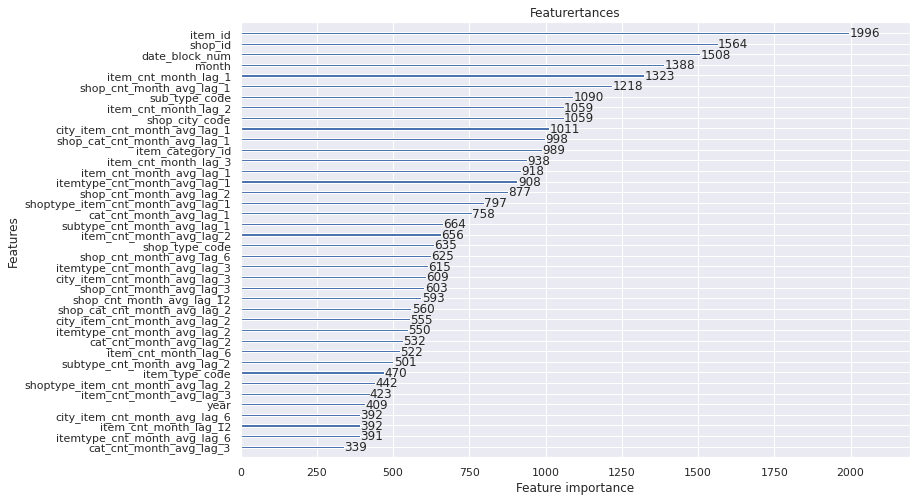

In [144]:
# 特征重要性画图
lgb.plot_importance(lgb_model, max_num_features=40, figsize=(12, 8))
plt.title("Featurertances")
plt.show()

In [145]:
lgb_model.save_model('model_bestscore02.txt')  # 保存模型

In [146]:
# 根据项目要求，把数据“裁剪”到[0,20]的区间。
Y_test = lgb_model.predict(X_test).clip(0, 20)
Y_test

array([0.59823041, 0.30494073, 1.01312552, ..., 0.09907698, 0.08673675,
       0.10266189])

In [147]:
X_test['item_cnt_month'] = Y_test
X_test

,date_block_num,shop_id,item_id,shop_type_code,shop_city_code,item_category_id,item_type_code,sub_type_code,year,month,...,city_item_cnt_month_avg_lag_2,city_item_cnt_month_avg_lag_3,city_item_cnt_month_avg_lag_6,city_item_cnt_month_avg_lag_12,shoptype_item_cnt_month_avg_lag_1,shoptype_item_cnt_month_avg_lag_2,shoptype_item_cnt_month_avg_lag_3,shoptype_item_cnt_month_avg_lag_6,shoptype_item_cnt_month_avg_lag_12,item_cnt_month
10840740,34,5,5037,3,4,19,5,2,2015,10,...,1.0,3.0,1.0,1.0,0.444444,2.00,4.250000,2.500000,1.250000,0.598230
10840741,34,5,5320,3,4,55,12,38,2015,10,...,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.304941
10840742,34,5,5233,3,4,19,5,2,2015,10,...,3.0,1.0,3.0,0.0,1.222222,2.50,4.500000,2.125000,0.000000,1.013126
10840743,34,5,5232,3,4,23,5,6,2015,10,...,0.0,1.0,0.0,0.0,0.555556,1.25,2.000000,0.000000,0.000000,0.410272
10840744,34,5,5268,3,4,20,5,3,2015,10,...,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,2.402465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11054935,34,45,18454,1,21,55,12,38,2015,10,...,0.0,0.0,0.0,0.0,0.111111,0.00,0.052632,0.666667,0.000000,0.163707
11054936,34,45,16188,1,21,64,13,47,2015,10,...,0.0,0.0,0.0,0.0,0.000000,0.05,0.000000,0.000000,0.000000,0.101655
11054937,34,45,15757,1,21,55,12,38,2015,10,...,0.5,0.0,0.0,0.0,0.166667,0.10,0.105263,0.142857,0.250000,0.099077
11054938,34,45,19648,1,21,40,10,24,2015,10,...,0.0,0.0,0.0,0.0,0.055556,0.05,0.263158,0.142857,0.000000,0.086737


In [148]:
#  将预测结果合并到测试集。
result = pd.merge(test[['ID', 'shop_id', 'item_id']],X_test[['shop_id','item_id','item_cnt_month']], on=['shop_id', 'item_id'], how='left')
result

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.598230
1,1,5,5320,0.304941
2,2,5,5233,1.013126
3,3,5,5232,0.410272
4,4,5,5268,2.402465
...,...,...,...,...
214195,214195,45,18454,0.163707
214196,214196,45,16188,0.101655
214197,214197,45,15757,0.099077
214198,214198,45,19648,0.086737


In [149]:
result.isna().any()

ID                False
shop_id           False
item_id           False
item_cnt_month    False
dtype: bool

前面分析关闭的商店中，有3个商在最近半年里只有最后一个月有销量，推断是新开的商店。
还有一些商品是最近半年都没有销量，推断是已经下架的商品，预测值填为0 。 

In [150]:
result[result.shop_id.isin(shop_c_n.columns)]['shop_id'].unique()

array([36])

In [151]:
result.loc[result.item_id.isin(item_zero), 'item_cnt_month'] = 0
result.loc[result.item_id.isin(item_zero), 'item_cnt_month']

298       0.0
493       0.0
817       0.0
953       0.0
1165      0.0
         ... 
214165    0.0
214167    0.0
214176    0.0
214179    0.0
214180    0.0
Name: item_cnt_month, Length: 7812, dtype: float64

In [152]:
result[['ID','item_cnt_month']].to_csv('fromfinal01.csv',sep=',',index=False)